# Python大作业


## 题目

用 numpy 实现神经网络全连接层，并使用所实现的神经网络完成以下某一任务（二选一）：

+ ■ 手写数字(mnist)数据集(sklearn.datasets.load_digits()) 上完成多分类任务
+ □ 糖尿病数据集(sklearn.datasets.load_diabetes()) 完成回归任务

## 要求
使用numpy库来实现模型，不可使用PyTorch, Keras, TensorFlow, PaddlePaddle, MXNet, Caffe, Theano等深度学习框架。 文档需要详细说明定义的每一个类 (class)、方法 (method) 及函数 (function)，以及整个代码实现 逻辑。
模型训练的过程或结果（loss值）需要绘图展示，且在文档中说明。 原则上要求仅使用numpy (用于建立模型)，scikit-learn (用于下载数据集) 及Python标准库，若有 其他需求需要和助教说明。

## 环境

+ windows 10 专业版 21H1
+ Python 3.9.2

## 目录
```
- nn
--- Layers.py
--- Loss.py
--- Model.py
--- optimizer.py
- demo.py
- requirements.txt
- Python程序设计作业.pdf
- README.ipynb
```


## 文件说明

+ 各种神经网络层
  [Layers.py](./nn/Layers.py)
  
+ 损失函数
  [Loss.py](./nn/Loss.py)

+ 神经网络模型
  [Model.py](./nn/Model.py)
    
+ 优化子
  [optimizer.py](./nn/optimizer.py)
    
+ 测试函数
  [demo.py](./demo.py)
    
+ 库版本
  [requirements.txt](./requirements.txt)

## 代码实现逻辑

+ 全连接层的实现难点主要集中在前向计算与反向传播的实现上
  + 其中前向计算实际上比较容易实现
  + 反向传播计算梯度较为困难
    + 在实践上，将每一层神经网络抽象成一个Layer
    + 每一个Layer都有自己的前一层和后一层
    + 在前向计算时，链式调用每一层后一层的forward函数即可
    + 在反向传播时，计算结束本层的梯度值后，需要继续调用前一层的backward函数继续计算前一层的梯度
    + 梯度计算结束后，让每一层的参数减去学习率乘梯度即可
    + 为简化代码，只在opt优化子中使用学习率lr乘一次梯度
  + 使用Relu作为全连接层的激活函数
  + 使用交叉熵作为模型训练的损失函数
  + 使用SGD(随机梯度下降法)作为优化函数
  + 本项目仅仅使用numpy库，并使用sklearn库获得mnist原始数据集，具体库环境可参考[requirements.txt](./requirements.txt)
  + 神经网络结构为
```
    网络类型  神经元个数  参数量
    Input       8*8         0
    Flatten     64          0
    Linear      64       4160
    Relu                    0
    Linear      10       4160
    Relu                    0
    Softmax                 
    Output      10          0
```
  + 训练集大小 1500
  + 测试集大小 297

In [1]:
import numpy as np


### Layers.py



#### 基类

In [2]:

class Layer(object):
    """神经网络层基类

        实现了神经网络层的基本、必要功能
        在此基类基础上，实现了Linear Relu Softmax Input Output Flatten层等

        属性:
            self.next_layer     :   该神经网络层的下一层
            self.last_layer     :   该神经网络层的上一层
            self.input_shape    :   该神经网络层的输入矩阵形状
            self.output_shape   :   该神经网络层的输出矩阵形状
            self.trainable      :   该神经网络层是否需要训练
            self.input          :   该神经网络层的输入矩阵
            self.output         :   该神经网络层的输出矩阵
            self.gradient       :   该神经网络层的梯度
    """

    def __init__(self, last_layer, trainable=True):
        """初始化函数

        :param last_layer   :   该神经网络层的上一层
        :param trainable    :   该神经网络层是否需要训练
        """
        self.next_layer = None
        self.last_layer = last_layer
        if self.last_layer is not None:
            self.last_layer.next_layer = self
        if self.last_layer is not None:
            self.input_shape = self.last_layer.output_shape
        else:
            self.input_shape = None
        self.trainable = trainable
        self.output_shape = None
        self.input = None
        self.output = None
        self.gradient = None

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入矩阵
        :return         :   无
        """
        pass

    def backward(self, gradient):
        """反向传播函数

        :param gradient :   该神经网络层的梯度
        :return         :   无
        """
        pass


#### 全连接层

In [3]:

class Linear(Layer):
    """全连接层

        最重要的神经网络层之一，实现了全连接层的功能

        属性:
            self.weights    :   全连接层的连接权重矩阵
            self.bias       :   全连接层的连接常数偏移量
    """

    def __init__(self, last_layer, output_units):
        """初始化函数

        :param last_layer   :   该全连接层的上一层
        :param output_units :   该全连接层的输出神经元数
        """
        super().__init__(last_layer=last_layer, trainable=True)
        self.output_shape = (output_units, 1)

        # 初始化连接矩阵权重
        limit = np.sqrt(6 / (self.input_shape[0] + self.output_shape[0]))
        self.weights = np.random.uniform(-1 * limit, limit,
                                         size=(self.input_shape[0], self.output_shape[0]))
        self.bias = np.zeros((self.output_shape[0], 1))

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入矩阵
        :return         :   无
        """
        self.input = input_x.copy()

        # 相当于y=wT*x+b
        self.output = self.weights.T.dot(self.input) + self.bias
        self.next_layer.forward(self.output)

    def backward(self, gradient):
        """反向传播函数

        :param gradient :   上一层的梯度值
        :return         :   无
        """
        self.gradient = gradient.copy()

        # 反向传播梯度
        last_layer_gradient = self.weights.dot(self.gradient)
        self.last_layer.backward(gradient=last_layer_gradient)

        # w的梯度系数实际上是输入矩阵x
        # b的梯度系数始终为1
        grad_for_w = np.tile(self.input.T, self.output_shape)

        # 更新参数
        self.weights -= (grad_for_w * self.gradient).T
        self.bias -= self.gradient


#### 输入层

In [4]:

class Input(Layer):
    """输入层

        接受起初输入的数据
        一轮训练开始时使用

    """

    def __init__(self, input_shape):
        """初始化函数

        :param input_shape:
        """
        super().__init__(last_layer=None, trainable=False)
        self.output_shape = input_shape

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入的数据
        :return         :   无
        """
        self.input = input_x.copy()
        self.next_layer.forward(input_x=input_x)


#### 输出层

In [5]:

class Output(Layer):
    """输出层

        输出最终计算得到的数据
        一轮训练结束时使用

    """

    def __init__(self, last_layer=None):
        """初始化函数

        :param last_layer   :   模型上一层
        """
        super().__init__(last_layer=last_layer, trainable=False)

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入矩阵
        :return         :   无
        """
        self.output = input_x.copy()

    def backward(self, gradient):
        """反向传播函数

        :param gradient :   上一层的梯度
        :return         :   无
        """
        self.gradient = gradient.copy()
        self.last_layer.backward(gradient=self.gradient)


#### 线性化层

In [6]:

class Flatten(Layer):
    """线性化层

        例如输入矩阵形状为(a, b, c), 则输出矩阵形状为(a*b*c, 1)

    """

    def __init__(self, last_layer=None):
        """初始化函数

        :param last_layer   :   模型的上一层
        """
        super().__init__(last_layer=last_layer, trainable=False)
        self.output_shape = (np.prod(self.input_shape), 1)

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   当前层的输入
        :return         :   无
        """
        self.input = input_x.copy()
        self.next_layer.forward(input_x=self.input.reshape(self.output_shape))

    def backward(self, gradient):
        """反向传播函数

        :param gradient :   当前层输出对损失函数的梯度
        :return         :   无
        """
        self.gradient = gradient.copy()
        last_layer_gradient = self.gradient.reshape(self.input_shape)
        self.last_layer.backward(gradient=last_layer_gradient)


#### 激活函数层（Relu）

In [7]:

class Relu(Layer):
    """非线性化激活层

        负责激活全连接层的输出，使神经网络非线性化

    """

    def __init__(self, last_layer=None):
        """初始化函数

        :param last_layer   : 该激活函数层的上一层
        """
        super().__init__(last_layer=last_layer, trainable=False)
        self.output_shape = self.input_shape

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入矩阵
        :return         :   无
        """
        self.input = input_x.copy()
        self.next_layer.forward(input_x=np.maximum(input_x, 0))

    def backward(self, gradient):
        """反向传播函数

        :param gradient :    梯度值
        :return         :    无
        """
        self.gradient = gradient.copy()

        # 根据Relu函数的分段特性知，
        #   如果输入大于0，对应位置的梯度等于上一层回传的梯度，否则为零
        select_mat = np.zeros(shape=self.input.shape)
        select_mat = np.greater(self.input, select_mat).astype(np.int32)
        last_layer_gradient = select_mat * self.gradient
        self.last_layer.backward(gradient=last_layer_gradient)


#### Softmax层

In [8]:

class Softmax(Layer):
    """Softmax多分类层

        负责将被激活的全连接层的输出结果归一化后计算分类

        属性:
            self.exp_input      :   输入矩阵的exp值
            self.sum_exp_input  :   输入矩阵的exp值的和
            self.tp             :   self.exp_input / self.sum_exp_input
                                    用于计算梯度
    """

    def __init__(self, last_layer=None):
        """初始化函数

        :param last_layer   :   模型的上一层
        """
        super().__init__(last_layer=last_layer, trainable=False)
        self.output_shape = self.input_shape
        self.exp_input = None
        self.sum_exp_input = None
        self.tp = None

    def forward(self, input_x):
        """前向计算函数

        :param input_x  :   输入矩阵
        :return         :   无
        """
        self.input = input_x.copy()
        self.exp_input = np.exp(self.input)
        self.sum_exp_input = np.sum(self.exp_input)
        self.output = self.exp_input / self.sum_exp_input
        self.next_layer.forward(input_x=self.output)

    def backward(self, gradient):
        """反向传播函数

        :param gradient     :   上一层的梯度
        :return             :   无
        """
        self.gradient = gradient.copy()
        self.tp = self.exp_input / self.sum_exp_input
        last_layer_gradient = np.zeros(
            shape=self.input_shape, dtype=np.float64)

        # 梯度计算
        for i in range(self.input_shape[0]):
            gradient_for_Ii = np.zeros(
                shape=self.input_shape, dtype=np.float64)

            # 分类标签值与预测值是否相等讨论
            for j in range(self.input_shape[0]):
                if i == j:
                    gradient_for_Ii[j] = self.output[i] * (1 - self.output[i])
                else:
                    gradient_for_Ii[j] = -1 * self.output[i] * self.output[j]

            last_layer_gradient[i] = np.sum(gradient_for_Ii * self.gradient)

        self.last_layer.backward(gradient=last_layer_gradient)


### Loss.py

In [9]:
class Cross_entropy(object):
    """交叉熵

        实现loss函数的计算（交叉熵）

        参数:
            self.output :   预测值
            self.target :   标签值
            self.error  :   交叉熵
    """

    def __init__(self):
        self.output = None
        self.target = None
        self.error = None

    def get_error(self, output, target):
        """

        :param output   :   预测值
        :param target   :   标签值
        :return         :   交叉熵
        """
        self.output = output
        self.target = target

        # 交叉熵计算
        self.error = -1 * np.sum(self.target * np.log(self.output))
        return self.error

    def get_gradient(self):
        """获得梯度值

        :return :   梯度值
        """
        return -1 * self.target / self.output


### Model.py

In [10]:

class Model(object):
    """神经网络模型

        神经网络模型，高层API

        属性:
            self.input_layer  :     模型的输入层
            self.output_layer :     模型的输出层
            self.loss         :     模型的损失函数
            self.opt          :     模型的优化子

    """

    def __init__(self, input_layer=None, output_layer=None, loss=None, opt=None):
        """初始化函数

        :param input_layer  :   模型的输入层
        :param output_layer :   模型的输出层
        :param loss         :   模型的损失函数
        :param opt          :   模型的优化子
        """
        self.input_layer = input_layer
        self.output_layer = output_layer
        self.loss = loss
        self.opt = opt
        self.opt.set_model(self)

    def fit(self, x_train, y_train, epochs=50, batch_size=1500):
        """模型训练函数

        :param x_train      :   用于训练的输入值
        :param y_train      :   用于训练的标签值
        :param epochs       :   训练的总轮数
        :param batch_size   :   训练的batch大小
        :return             :   训练过程中的loss值

        """

        # 用于跟踪训练过程中的loss值
        E = []

        train_size = x_train.shape[0]

        # 对于训练的每一轮
        for epoch in range(epochs):
            e = 0

            # 随机选择batch_size大小数据集训练
            for i in range(batch_size):
                ridx = np.sum(np.random.randint(0, train_size, (1,)))
                error = self.train_once(
                    input_x=x_train[ridx], target=y_train[ridx])
                e += error
            E.append(e / batch_size)
            print('epoch:', epoch, '  loss:', e / batch_size)
        return E

    def predict(self, input_x):
        """预测函数

        :param input_x  :   需要预测的输入值
        :return         :   模型的输出值

        """
        self.input_layer.forward(input_x=input_x)
        output = self.output_layer.output
        return output

    def train_once(self, input_x, target):
        """

        :param input_x  :   输入数据
        :param target   :   训练目标（标签值）
        :return         :   单次训练的loss值

        """
        self.input_layer.forward(input_x=input_x)
        output = self.output_layer.output

        # 单次训练的loss值
        error = self.loss.get_error(output=output, target=target)
        self.output_layer.gradient = self.loss.get_gradient()

        # 优化子步进，更新参数
        self.opt.step()
        return error


### optimizer.py

In [11]:
class SGD(object):
    """随机梯度下降法

        参数:
            self.model      :   该优化子的目标优化模型
            self.lr         :   该优化子的学习率
            self.momentum   :   随机梯度下降法的动量系数
            self.mt         :   当前的累计动量值
    """

    def __init__(self, lr=0.05, momentum=0.0):
        """初始化函数

        :param lr       :   学习率
        :param momentum :   动量系数
        """
        self.model = None
        self.lr = lr
        self.momentum = momentum
        self.mt = 0

    def set_model(self, model):
        """设置该优化子的目标优化模型

        :param model    :   该优化子的目标优化模型
        :return         :   无
        """
        self.model = model

    def step(self):
        """优化子步进一步（开启反向传播优化）

        :return :   无
        """
        self.mt = self.momentum * self.mt + self.lr * self.model.output_layer.gradient
        self.model.output_layer.backward(self.mt)


## 测试代码

### 函数库调用

In [12]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets

from nn import Loss
from nn.Layers import Input, Output, Linear, Relu, Softmax, Flatten
from nn.Model import Model
from nn.optimizer import SGD

### 数据集展示测试

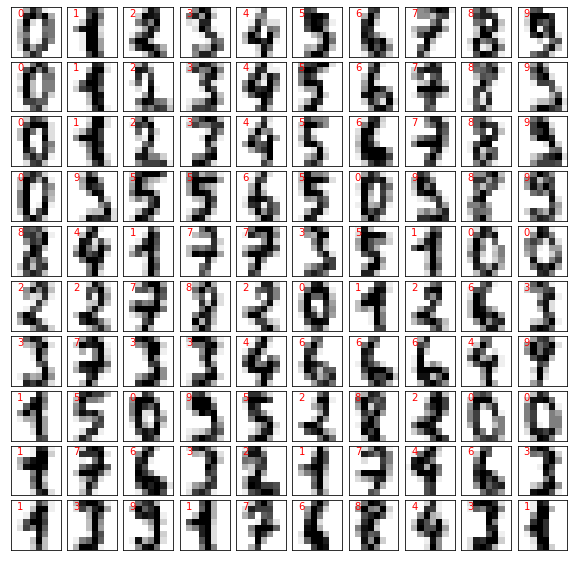

In [13]:
def draw_test():
    """数据集展示测试

    :return :   无
    """
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    digits = datasets.load_digits()
    X = np.array(digits.images)
    Y = np.array(digits.target)
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(8, 8), cmap="binary")
        ax.text(0.5, 1, str(Y[i]), color="red")
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

draw_test()

### 全连接神经网络实现mnist数据集分类测试

+ 设置随机种子，保证可复现

In [14]:
np.random.seed(0)


+ 总类数

In [15]:
n_classes = 10


+ 获得数据集

In [16]:
digits = datasets.load_digits()
X = np.array(digits.images)
Y = np.array(digits.target)


+ 数据集变形预处理

In [17]:
X = np.expand_dims(X, -1) / 255
Y = np.expand_dims(np.eye(n_classes)[Y], -1)


+ 分割数据集

In [18]:
x_train = X[:1500, ]
y_train = Y[:1500, ]
x_test = X[1500:, ]
y_test = Y[1500:, ]


+ 声明构建每一层神经网络

In [19]:
input_layer = Input(input_shape=(8, 8, 1))
flatten = Flatten(last_layer=input_layer)
d1 = Linear(output_units=64, last_layer=flatten)
r1 = Relu(last_layer=d1)
d3 = Linear(output_units=64, last_layer=r1)
r3 = Relu(last_layer=d3)
d2 = Linear(output_units=10, last_layer=r3)
r2 = Relu(last_layer=d2)
sm = Softmax(last_layer=r2)
output = Output(last_layer=sm)


+ 随机梯度下降优化子

In [20]:
opt = SGD(lr=0.05, momentum=0.)


+ 交叉熵损失函数

In [21]:
ce = Loss.Cross_entropy()


+ 模型构建

In [22]:
model = Model(input_layer=input_layer, output_layer=output, loss=ce, opt=opt)


+ 模型训练

In [23]:
losses = model.fit(x_train=x_train, y_train=y_train,
                   epochs=50, batch_size=1500)


epoch: 0   loss: 2.2957299251111203
epoch: 1   loss: 2.2208298867882355
epoch: 2   loss: 2.0580808405023983
epoch: 3   loss: 1.9191651491487265
epoch: 4   loss: 1.8027993713890338
epoch: 5   loss: 1.7945001544279133
epoch: 6   loss: 1.856467826774613
epoch: 7   loss: 1.7788102294067885
epoch: 8   loss: 1.8017467414519146
epoch: 9   loss: 1.7945354451705868
epoch: 10   loss: 1.7325826488127578
epoch: 11   loss: 1.711309777727397
epoch: 12   loss: 1.7262191360159398
epoch: 13   loss: 1.7139832885766297
epoch: 14   loss: 1.6822486617455286
epoch: 15   loss: 1.7013113422284885
epoch: 16   loss: 1.7207912043941778
epoch: 17   loss: 1.9247187669657857
epoch: 18   loss: 1.918834414628251
epoch: 19   loss: 1.8701110241846866
epoch: 20   loss: 1.8775222884229108
epoch: 21   loss: 1.4645606388615748
epoch: 22   loss: 1.407349284504473
epoch: 23   loss: 1.1907992737918782
epoch: 24   loss: 1.0308020893216963
epoch: 25   loss: 0.9667439679951303
epoch: 26   loss: 0.7642384565366714
epoch: 27   los

+ 模型测试

In [24]:
cnt = 0
for i in range(x_test.shape[0]):
    o = model.predict(input_x=x_test[i])
    o = o[..., 0]
    t = y_test[i][..., 0]

    pl = np.argmax(o)
    pt = np.argmax(t)
    if pl == pt:
        cnt += 1
print('accruacy is ', cnt / x_test.shape[0])


accruacy is  0.9259259259259259


+ 绘制loss变化曲线及前十张图片的测试结果

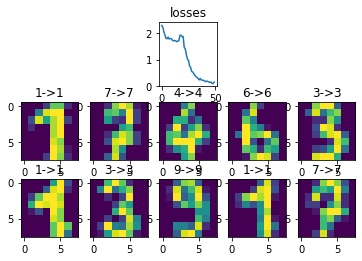

In [25]:
# 绘制loss变化曲线
plt.xlabel("epochs")
plt.subplot(3, 5, 3)
plt.title("losses")
plt.plot(losses)

# 绘制前十张图片的测试结果
for i in range(10):
    pred = model.predict(input_x=x_test[i])
    pred = pred[..., 0]
    t = y_test[i][..., 0]
    pl = np.argmax(pred)
    pt = np.argmax(t)
    plt.subplot(3, 5, i + 6)
    plt.title("{}->{}".format(pt, pl))
    plt.imshow(x_test[i].reshape(8, 8))
plt.show()
